In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# GPU verification
print(f"CUDA available: {torch.cuda.is_available()}")

transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.512, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.512, 0.225])
])

train_dataset = datasets.ImageFolder('./data/train', transform=transform_train)
test_dataset = datasets.ImageFolder('./data/test', transform=transform_test)

# Optimized data loaders for better GPU utilization
# Fixed data loaders for Windows
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                         num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, 
                        num_workers=0, pin_memory=True)


print(f"Classes: {train_dataset.classes}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")


CUDA available: False
Classes: ['Augmented Banana Black Sigatoka Disease', 'Augmented Banana Bract Mosaic Virus Disease', 'Augmented Banana Healthy Leaf', 'Augmented Banana Insect Pest Disease', 'Augmented Banana Moko Disease', 'Augmented Banana Panama Disease', 'Augmented Banana Yellow Sigatoka Disease']
Number of training samples: 2423
Number of test samples: 433


In [4]:
class BananaCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BananaCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1 - Reduced channels
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 2
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 3
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),  # Smaller pooling
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),   # Smaller linear layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BananaCNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model will train on: {device}")


Model will train on: cpu


In [5]:
# transform_train = transforms.Compose([
#     transforms.Resize((512, 512)),  # Reduced from 512x512
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.512, 0.225])
# ])

# transform_test = transforms.Compose([
#     transforms.Resize((512, 512)),  # Reduced from 512x512
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.512, 0.225])
# ])


In [6]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    train_accuracies = []
    
    # Create main models directory
    os.makedirs('saved_models', exist_ok=True)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Save model for this epoch
        epoch_folder = f'saved_models/epoch_{epoch+1:02d}'
        os.makedirs(epoch_folder, exist_ok=True)
        torch.save(model.state_dict(), f'{epoch_folder}/banana_cnn_epoch_{epoch+1:02d}.pth')
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        print(f'Model saved to {epoch_folder}/')
        print(f"GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    
    return train_losses, train_accuracies

# Train the model
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20)


c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch [1/20], Loss: 1.3114, Accuracy: 45.07%
Model saved to saved_models/epoch_01/
GPU memory: 0.00 GB
Epoch [2/20], Loss: 0.9620, Accuracy: 58.94%
Model saved to saved_models/epoch_02/
GPU memory: 0.00 GB
Epoch [3/20], Loss: 0.8716, Accuracy: 63.76%
Model saved to saved_models/epoch_03/
GPU memory: 0.00 GB
Epoch [4/20], Loss: 0.8206, Accuracy: 66.74%
Model saved to saved_models/epoch_04/
GPU memory: 0.00 GB
Epoch [5/20], Loss: 0.7544, Accuracy: 69.79%
Model saved to saved_models/epoch_05/
GPU memory: 0.00 GB
Epoch [6/20], Loss: 0.7101, Accuracy: 72.14%
Model saved to saved_models/epoch_06/
GPU memory: 0.00 GB
Epoch [7/20], Loss: 0.6655, Accuracy: 73.88%
Model saved to saved_models/epoch_07/
GPU memory: 0.00 GB
Epoch [8/20], Loss: 0.6304, Accuracy: 74.21%
Model saved to saved_models/epoch_08/
GPU memory: 0.00 GB
Epoch [9/20], Loss: 0.6157, Accuracy: 75.07%
Model saved to saved_models/epoch_09/
GPU memory: 0.00 GB
Epoch [10/20], Loss: 0.5692, Accuracy: 77.38%
Model saved to saved_models

In [7]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(7))
    class_total = list(0. for i in range(7))
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_accuracy = 100 * correct / total
    print(f'Test Accuracy: {overall_accuracy:.2f}%')
    
    # Print per-class accuracy
    for i in range(7):
        if class_total[i] > 0:
            print(f'{train_dataset.classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

# Evaluate the model
evaluate_model(model, test_loader)


Test Accuracy: 85.68%
Augmented Banana Black Sigatoka Disease: 74.65%
Augmented Banana Bract Mosaic Virus Disease: 90.57%
Augmented Banana Healthy Leaf: 97.80%
Augmented Banana Insect Pest Disease: 93.41%
Augmented Banana Moko Disease: 79.31%
Augmented Banana Panama Disease: 72.73%
Augmented Banana Yellow Sigatoka Disease: 72.00%


In [9]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the same model architecture
class BananaCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BananaCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Class names
class_names = ['Sigatoka Disease', 
               'Bract Mosaic Virus Disease', 
               'Healthy Leaf', 
               'Insect Pest Disease', 
               'Moko Disease', 
               'Panama Disease', 
               'Yellow Sigatoka Disease']

# Prediction function
def predict_image(image_path, model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    model = BananaCNN(num_classes=7).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Transform for prediction
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.512, 0.225])
    ])
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        predicted_class = torch.argmax(outputs, 1).item()
        confidence = probabilities[predicted_class].item()
    
    # Display results
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.bar(range(len(class_names)), probabilities.cpu().numpy())
    plt.xticks(range(len(class_names)), [name.replace('Augmented Banana ', '') for name in class_names], rotation=45)
    plt.title('Prediction Probabilities')
    plt.tight_layout()
    plt.show()
    
    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.2%}")
    
    return predicted_class, confidence

# Usage example
# predict_image('path/to/your/test_image.jpg', 'saved_models/epoch_20/banana_cnn_epoch_20.pth')


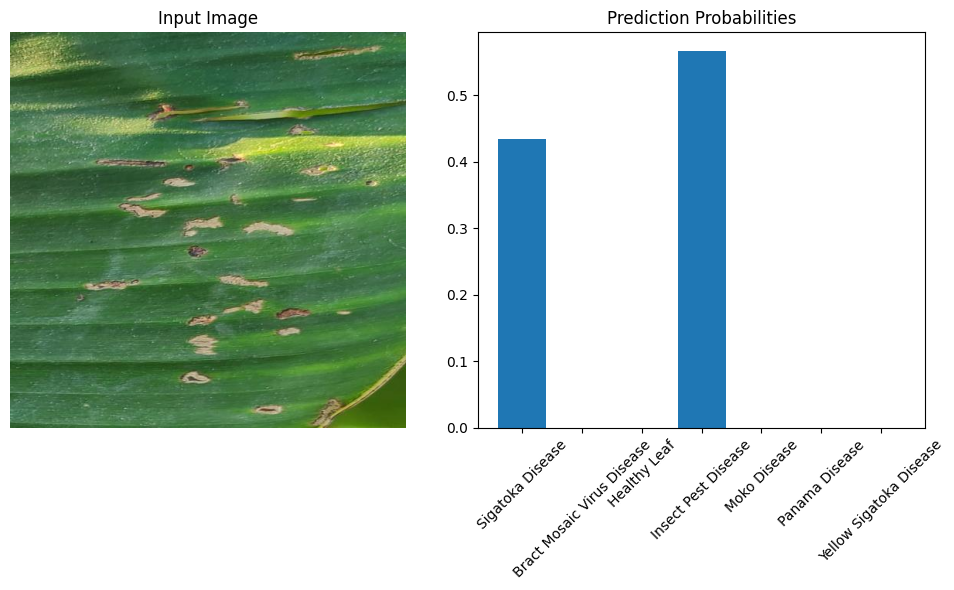

Predicted Class: Insect Pest Disease
Confidence: 56.61%


(3, 0.5661026239395142)

In [39]:
predict_image('./prediction/in.jpg', 'saved_models/epoch_20/banana_cnn_epoch_20.pth')